In [1]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
PLOT_PARAMS()
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import pickle
import thejoker as tj
import pymc as pm
import corner
import arviz as az
plt.rcParams['figure.facecolor'] = 'white'
import warnings
warnings.filterwarnings("ignore")

from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

08_06_25


In [2]:
rv_df = pd.read_csv('comb_rvs.csv')

In [3]:
def clean_up(df):
    time = df['comb_time']
    rv = df['comb_rv']
    err = df['comb_rv_err']
    
    time = time.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    time = [str(t) for t in time if len(t) > 0]
    time = [float(t.split('\n')[0].replace("'","")) for t in time]
    
    rv = rv.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    rv = [t for t in rv if len(t) > 0]
    rv = [float(t.split('\n')[0]) for t in rv]
    
    err = err.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    err = [t for t in err if len(t) > 0]
    err = [float(t.split('\n')[0]) for t in err]
    
    return time, rv, err


In [4]:
obj_to_run = {}
plt.rcParams['figure.facecolor']    = 'white'

In [6]:
# dtemp = rv_df[(rv_df.RG_id==11) & (rv_df.program==112)]
# time, rv, err  = clean_up(dtemp)
# plt.scatter(time, rv)

In [41]:
def test_tj(obj,program,Pi,Pf=1000,K0=20, max_posterior=256, error=0.1,chains=2, prior_size=50_000,save=False,MCMC=False):
    plt.rcParams['figure.facecolor']    = 'white'
    data           = Table()
    dtemp          = rv_df[(rv_df.RG_id==obj) & (rv_df.program==program)]
    time, rv, err  = clean_up(dtemp)
    time, rv, err  = np.array(time), np.array(rv), np.array(err)
#     if obj == 16 and program==113:
#         time=time[:-1]
#         rv=rv[:-1]
#         err=err[:-1]

    if program == 113 and obj in [5, 16, 11, 21, 18]: #exclude galah data point
        mask = (time >= 2460000.)
        time, rv, err = time[mask], rv[mask], err[mask]
    elif program == 112 and obj in [7, 23]:  #exclude galah data point
        mask = (time >= 2460000.)
        time, rv, err = time[mask], rv[mask], err[mask]
    err            = np.array(err)
    print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    err[(err<0.10)] = 0.10
    
    data['bjd']    = time
    data['rv']     = rv
    data['rv_err'] = err

    print('error range: %.2f-%.2f' % (min(err),max(err)))
    
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        #P_prior = xu.with_unit(pm.Uniform("P", 0.25, 1e3), u.day)
        #M0_prior    = xu.with_unit(pm.Uniform("M0", -np.pi, np.pi), u.radian)
        #omega_prior = xu.with_unit(pm.Uniform("omega", -np.pi, np.pi), u.radian)
        
        #s_prior = xu.with_unit(pm.Normal("s", 0, 0.5), u.km/u.s)
        #K_prior = xu.with_unit(pm.Normal("K", 0, 20), u.km/u.s)
        #e_prior = xu.with_unit(pm.Uniform("e", 0, 1), u.one)
        
        prior = tj.JokerPrior.default(
                P_min = Pi * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = Pf * u.day,
                sigma_K0 = K0 * u.km / u.s,
                sigma_v = 100 * u.km / u.s,
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    print(min(prior_samples['P']))
    
    joker = tj.TheJoker(prior, rng=rnd)

    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=256,
                                           return_all_logprobs=True)

#     fig, ax = plt.subplots(1, 1, figsize=(8, 4))
#     _ = tj.plot_rv_curves(
#         joker_samples[0],
#         data=data,
#         relative_to_t_ref=True,
#         ax=ax,
#     )

#     ax.set_xlabel(f"BMJD$ - {data.t.tcb.mjd.min():.3f}$")
    if save: fig.savefig('../rv_fit/fit_%s_RG%s_%s.png'%(program,obj,DATE),bbox_inches='tight',dpi=100)
    
    if len(joker_samples[0]) == 1:
        with prior.model:
            mcmc_init = joker.setup_mcmc(data, joker_samples[0])
            trace = pm.sample(tune=2000, draws=2000, start=mcmc_init, cores=1, chains=chains)

        az.summary(trace, var_names=prior.par_names)
        print('MCMC samples...')
        mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
        mcmc_samples.wrap_K()
        df = mcmc_samples.tbl.to_pandas()
        colnames = []
        # ==== 3 body ====
        #truth = ['P','e','omega','M0','K','v0', 'v1', 'v2','s']
        #truth = ['P','e','K','v0', 'v1', 'v2','s']
        # ==== 2 body ====
        #truth = ['P','e','omega','M0','K','v0','s']
        truth = ['P','e','K','v0']
        for name in df.columns:
            if name in truth:
                colnames.append(name)
                #truths.append(truth[name].value)
        fig = corner.corner(df[colnames], 
                            labels=colnames,
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True,
                            title_kwargs={"fontsize": 12}) #, truths=truths)
        if save: fig.savefig('../rv_fit/corner_%s_RG%s_%s.png'%(program, obj, DATE),bbox_inches='tight',dpi=200)
        return prior_samples, joker_samples, mcmc_samples, trace, prior.par_names#az.summary(trace, var_names=prior.par_names)
    else:
        joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=max_posterior,
                                           return_all_logprobs=True)

        fig, ax = plt.subplots(1, 1, figsize=(8, 4))
        _ = tj.plot_rv_curves(
            joker_samples[0],
            data=data,
            relative_to_t_ref=True,
            ax=ax,
        )
    
        return prior_samples, joker_samples, -999, -999, prior.par_names#az.summary(trace, var_names=prior.par_names)



In [37]:
obj_to_run[23][0][1][0]

<JokerSamples [P, e, omega, M0, s, K, v0] (256 samples)>

error range: 0.07-0.37
error range: 0.10-0.37
1.0000198884057623 d


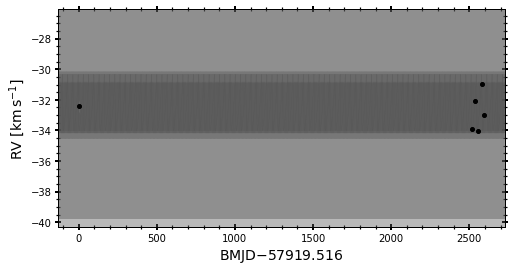

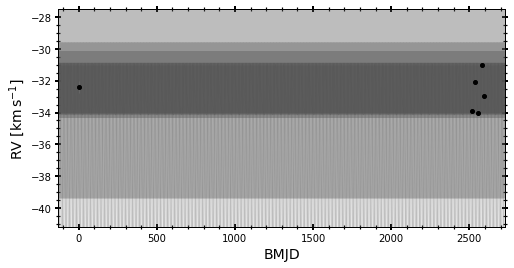

In [86]:
data_113_19 = test_tj(19, 113, max_posterior=10_000, Pi=1, Pf=3000, chains=2, prior_size=1_000_000, save=True, MCMC=True)


In [91]:
data_113_19

(<JokerSamples [e, omega, M0, s, P] (1000000 samples)>,
 (<JokerSamples [P, e, omega, M0, s, K, v0] (8 samples)>,
  array([-325.7233909 , -299.96996903, -278.3538106 , ..., -275.76913702,
         -307.41153678, -158.70450831])),
 -999,
 -999,
 ['P', 'e', 'omega', 'M0', 's', 'K', 'v0'])

Text(0, 0.5, 'Eccentricity')

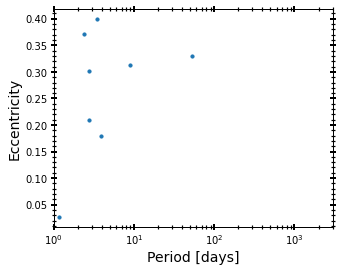

In [89]:
plt.figure(figsize=(5,4))
plt.scatter(data_113_19[1][0]['P'].value,data_113_19[1][0]['e'].value,s=10)
plt.xscale("log")
plt.xlim(1., 3e3)
plt.xlabel('Period [days]')
plt.ylabel('Eccentricity')


# change s 

error range: 0.01-0.05
error range: 0.10-0.10
1.0000198884057623 d


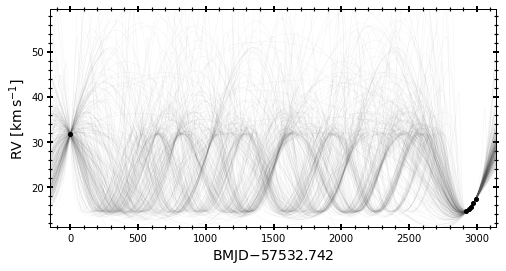

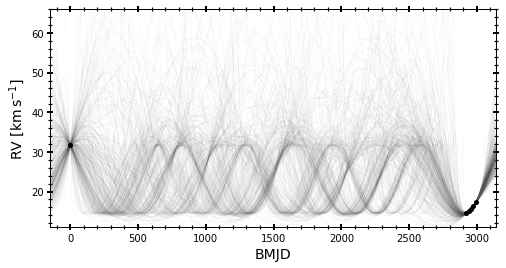

In [81]:
data_113_23 = test_tj(23, 113, max_posterior=100_000, Pi=1, Pf=3000, chains=2, prior_size=1_000_000, save=True, MCMC=True)


361


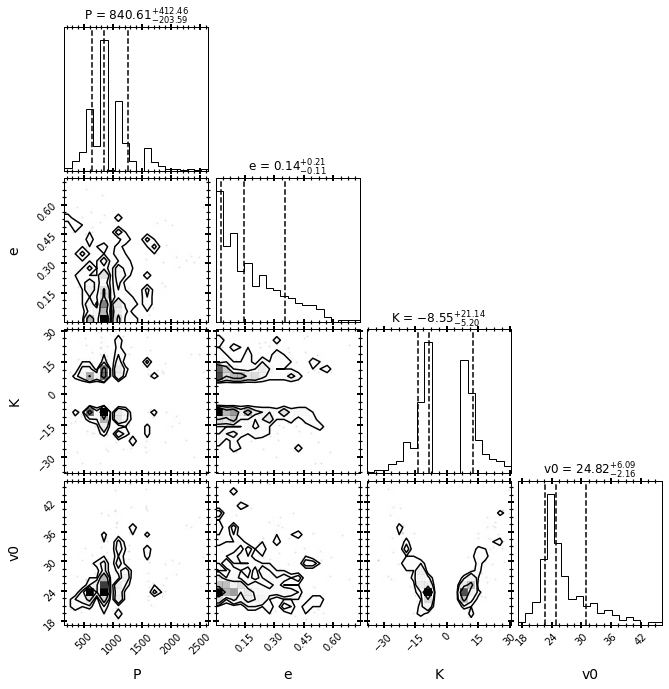

In [84]:
print(len(data_113_23[1][0]))
data = pd.DataFrame({'P': data_113_23[1][0]['P'].value, 
                     'e': data_113_23[1][0]['e'].value, 
                     'K': data_113_23[1][0]['K'].value, 
                     'v0': data_113_23[1][0]['v0'].value, 
                    })
# Plot it.
figure = corner.corner(
    data,
    labels=['P','e','K','v0'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)


error range: 0.06-0.11
error range: 0.10-0.11
1.0000001377729428 d


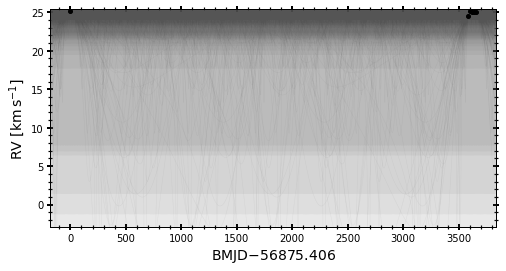

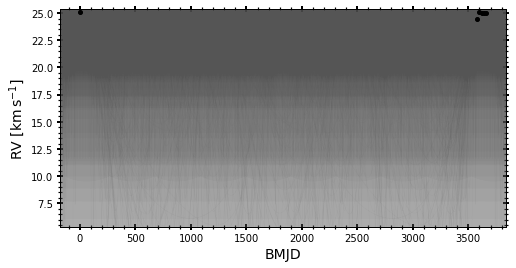

In [74]:
data_113_1 = test_tj(1, 113, max_posterior=100_000, Pi=1, Pf=3000, chains=2, prior_size=10_000_000, save=True, MCMC=True)


1032


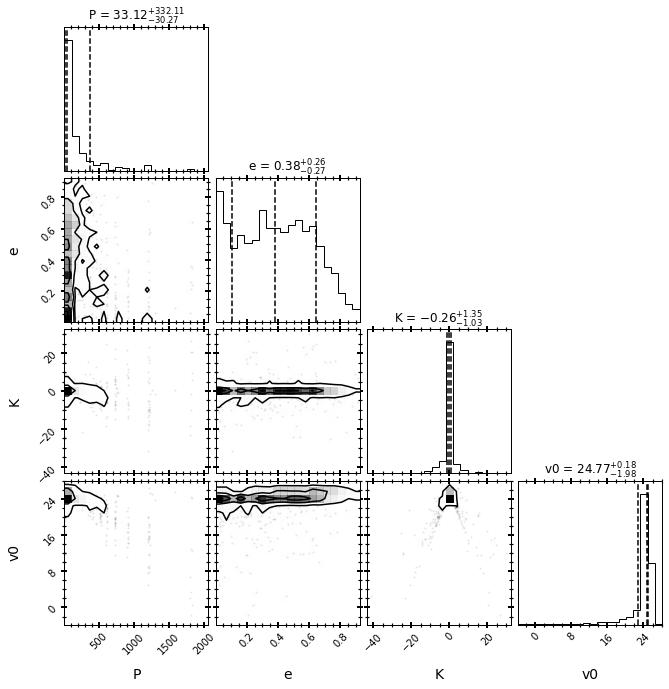

In [78]:
print(len(data_113_1[1][0]))
data = pd.DataFrame({'P': data_113_1[1][0]['P'].value, 
                     'e': data_113_1[1][0]['e'].value, 
                     'K': data_113_1[1][0]['K'].value, 
                     'v0': data_113_1[1][0]['v0'].value, 
                    })
# Plot it.
figure = corner.corner(
    data,
    labels=['P','e','K','v0'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)


error range: 0.01-0.06
error range: 0.10-0.10
1.0000198884057623 d


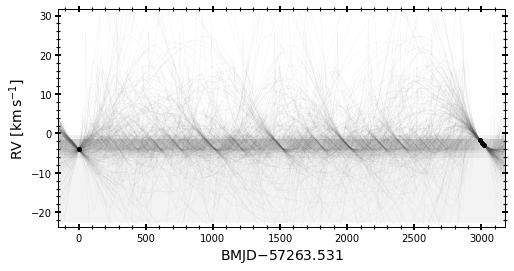

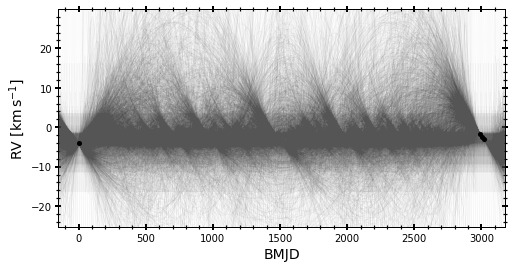

In [46]:
data_112_6 = test_tj(6, 112, max_posterior=1_000_000, Pi=1, Pf=3000, chains=2, prior_size=1_000_000, save=True, MCMC=True)

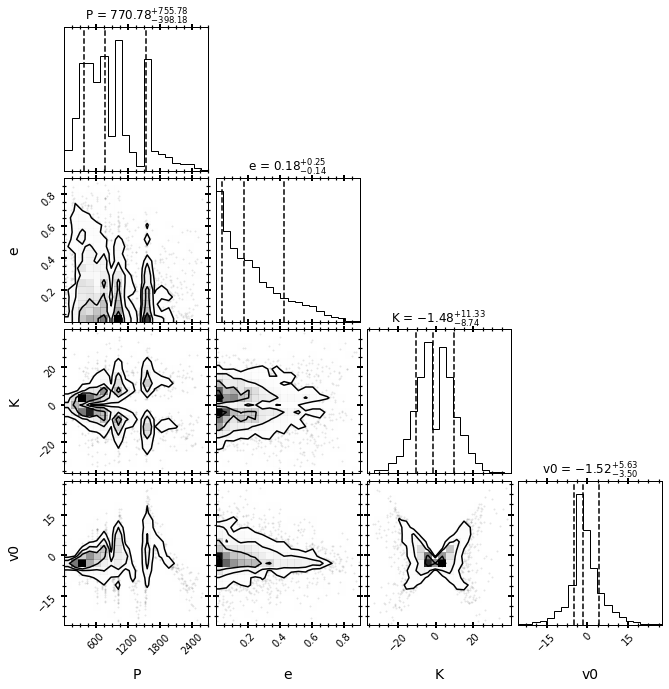

In [70]:
import corner

# data_112_6[1][0]['P'].value
data = pd.DataFrame({'P': data_112_6[1][0]['P'].value, 
                     'e': data_112_6[1][0]['e'].value, 
                     'K': data_112_6[1][0]['K'].value, 
                     'v0': data_112_6[1][0]['v0'].value, 
                    })
# Plot it.
figure = corner.corner(
    data,
    labels=['P','e','K','v0'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
)


Text(0, 0.5, 'Eccentricity')

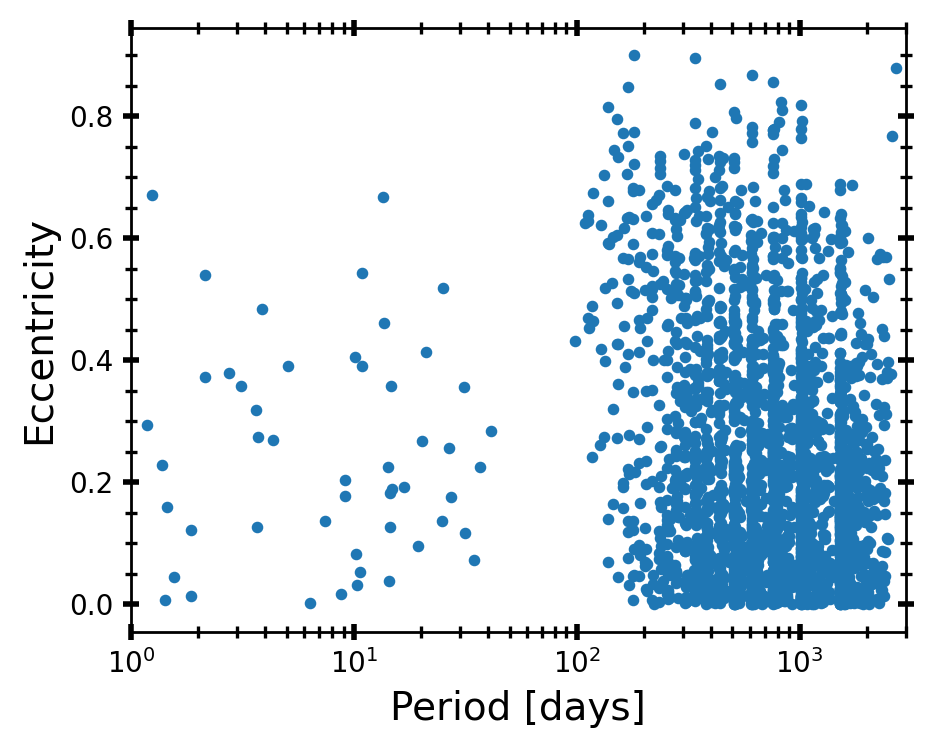

In [57]:
plt.figure(figsize=(5,4),dpi=200)
plt.scatter(data_112_6[1][0]['P'].value,data_112_6[1][0]['e'].value,s=10)
plt.xscale("log")
plt.xlim(1., 3e3)
plt.xlabel('Period [days]')
plt.ylabel('Eccentricity')

6
error range: 0.01-0.06
error range: 0.10-0.10
1.000122242830177 d
<JokerSamples [P, e, omega, M0, s, K, v0] (256 samples)>


NameError: name 'ss' is not defined

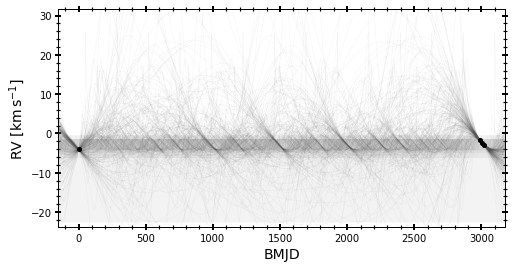

In [31]:
program = 112
version  = 23

# 113-1, v=18, P=2-200 :
# 113-1, v=19, P=2-1000 :
# 113-1, v=20, P=20-200 :
# 113-1, v=21, P=20-150 :
# 113-1, v=22, P=10-200 :
# 113-1, v=23, P=70-150 :

for k in [6]:
    print(k)
    obj_to_run[k] = [test_tj(k, program, Pi=1, Pf=3000, chains=2, prior_size=100_000, save=True, MCMC=True)]

    # save mcmc
    save_dir = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save trace
    save_dir = '../mcmc/%s_%s_trace_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save joker samples
    save_dir = '../mcmc/%s_%s_joker_%s.hdf5'%(program,k,version)
    obj_to_run[k][0][1][0].write(save_dir, overwrite=True)


18
error range: 0.02-0.09
error range: 0.10-0.10
10.000870849671658 d
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


NameError: name 'ss' is not defined

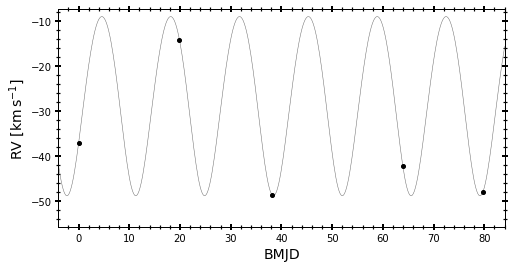

In [30]:
program = 113
version  = 24

# 113-1, v=18, P=2-200 :
# 113-1, v=19, P=2-1000 :
# 113-1, v=20, P=20-200 :
# 113-1, v=21, P=20-150 :
# 113-1, v=22, P=10-200 :
# 113-1, v=23, P=70-150 :

for k in [18]:
    print(k)
    obj_to_run[k] = [test_tj(k, program, Pi=10, Pf=3000, chains=2, prior_size=100_000, save=True, MCMC=True)]

    # save mcmc
    save_dir = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save trace
    save_dir = '../mcmc/%s_%s_trace_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save joker samples
    save_dir = '../mcmc/%s_%s_joker_%s.hdf5'%(program,k,version)
    obj_to_run[k][0][1][0].write(save_dir, overwrite=True)


16
error range: 0.08-0.11
error range: 0.10-0.11
5.000025685124978 d
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, K, v0]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 606 seconds.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


MCMC samples...


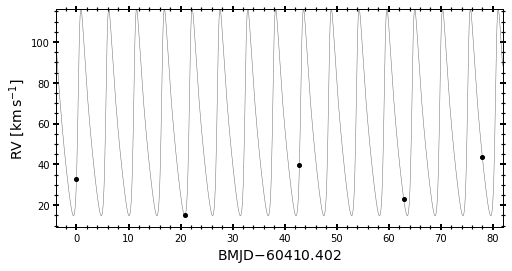

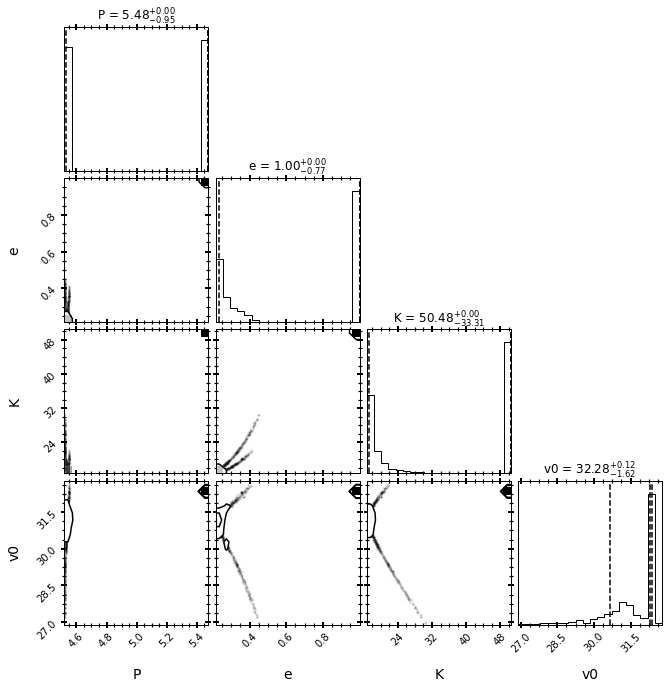

In [9]:
program = 113
version  = 23

# 113-1, v=18, P=2-200 : 
# 113-1, v=19, P=2-1000 : 
# 113-1, v=20, P=20-200 : 
# 113-1, v=21, P=20-150 : 
# 113-1, v=22, P=10-200 : 
# 113-1, v=23, P=70-150 : 

for k in [16]:
    print(k)
    obj_to_run[k] = [test_tj(k, program, Pi=5, Pf=7, chains=2, prior_size=100_000, save=True, MCMC=True)]

    # save mcmc
    save_dir = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save trace
    save_dir = '../mcmc/%s_%s_trace_%s.pickle'%(program,k,version)
    with open(save_dir, 'wb') as handle:
        pickle.dump(obj_to_run[k][0][-2], handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save joker samples
    save_dir = '../mcmc/%s_%s_joker_%s.hdf5'%(program,k,version)
    obj_to_run[k][0][1][0].write(save_dir, overwrite=True)


In [ ]:
ss